In [1]:
# ============================================================
# 🏦 Sentiment Analysis for Banking Texts using DistilBERT
# Dataset: Financial PhraseBank (100% Agreement version)
# Optimized for CPU with metrics & plots (incl. ROC/AUC)
# ============================================================

# Import libraries
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer,  DistilBertForSequenceClassification, Trainer, TrainingArguments
import evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

C:\Users\Iverson\anaconda3\envs\captum\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Use all available CPU threads
torch.set_num_threads(torch.get_num_threads()-1)

In [35]:
# Load dataset
df = pd.read_csv('../datasets/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt',
                 sep='@',header=None,encoding='latin-1',
                 names=['sentence','sentiment'])

# Encode Labels
label_map = {'positive':2,'neutral':1,'negative':0}
df['label'] = df['sentiment'].map(label_map)

# Train test spilt
train_X, test_X, train_y, test_y = train_test_split(
    df['sentence'].values,
    df['label'].values,
    test_size = 0.2,
    random_state=42
)

# Tokeniation, limit sequence length to 128
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [36]:
train_encodings = tokenizer.batch_encode_plus(train_X,padding=True,truncation=True,max_length=128,return_tensors='pt')
test_encodings = tokenizer.batch_encode_plus(test_X,padding=True,truncation=True,max_length=128,return_tensors='pt')

In [37]:
train_encodings['input_ids'].shape

torch.Size([1811, 93])

In [3]:
# Build dataset class for trainer
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self,encodings,labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        item = {key:val[idx] for key,val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [67]:
train_ds = SentimentDataset(train_encodings,train_y)
test_ds = SentimentDataset(test_encodings,test_y)

In [68]:
# Load pre-trained DistillBert model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Define metrics (accuracy)
metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits,axis=-1)
    return metric.compute(predictions=preds,references=labels)

In [70]:
# Training Arguments (tuned for CPU)
training_args = TrainingArguments(
    output_dir = './results',
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    learning_rate = 2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20
)

In [71]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [72]:
train_encodings.keys()

KeysView({'input_ids': tensor([[  101,  1996, 15873,  ...,     0,     0,     0],
        [  101,  4082,  5618,  ...,     0,     0,     0],
        [  101,  6983,  8139,  ...,     0,     0,     0],
        ...,
        [  101,  1036, 13649,  ...,     0,     0,     0],
        [  101,  3006,  2951,  ...,     0,     0,     0],
        [  101,  6636, 26557,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])})

In [73]:
# Start model training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.235500,0.165987,0.947020


TrainOutput(global_step=453, training_loss=0.3624989903525801, metrics={'train_runtime': 397.1348, 'train_samples_per_second': 4.56, 'train_steps_per_second': 1.141, 'total_flos': 43576083126846.0, 'train_loss': 0.3624989903525801, 'epoch': 1.0})

In [76]:
# Evaluate with detailed metrics
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions,axis=-1)
y_true = predictions.label_ids
y_probs = torch.softmax(torch.tensor(predictions.predictions),dim=1).numpy()

In [78]:
# Classification report
print('Classification Report')
print(classification_report(y_true,y_pred,target_names=['negative','neutral','positive']))

Classification Report
              precision    recall  f1-score   support

    negative       0.90      0.93      0.91        56
     neutral       0.96      0.98      0.97       276
    positive       0.95      0.88      0.91       121

    accuracy                           0.95       453
   macro avg       0.93      0.93      0.93       453
weighted avg       0.95      0.95      0.95       453



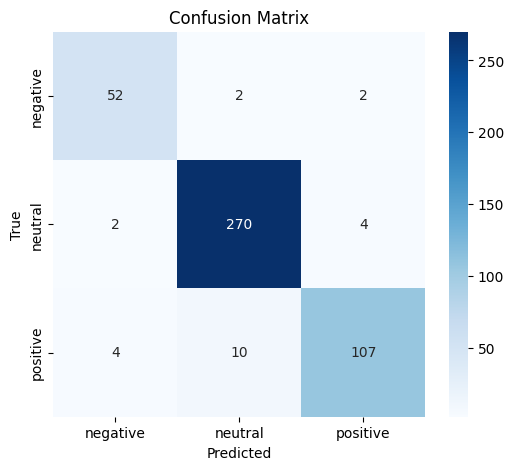

In [80]:
# Confusion Matrix
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
            xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
ax = sns.barplot(flights, x="year", y="passengers", estimator="sum", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10);

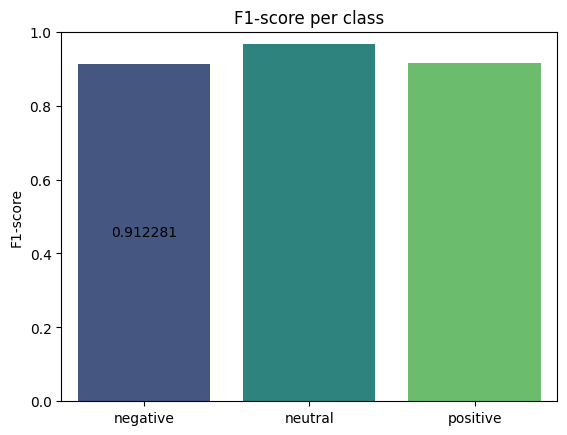

In [91]:
# Bar chart for F1-score
report = classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"], output_dict=True)
f1_scores = [report[label]['f1-score'] for label in ['negative','neutral','positive']]

ax = sns.barplot(x=['negative','neutral','positive'], y=f1_scores,palette='viridis')
ax.bar_label(ax.containers[0], fontsize=10,label_type='center');
plt.title('F1-score per class')
plt.ylabel('F1-score')
plt.ylim(0,1)
plt.show()

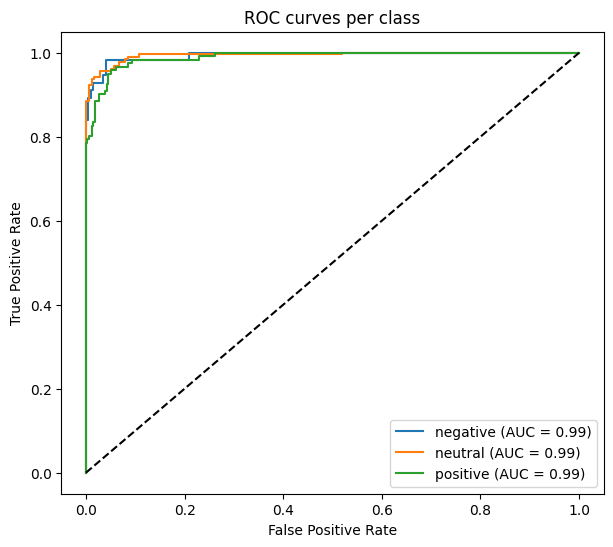

In [92]:
# ROC AUC curves for each class
n_classes = 3
y_true_bin = label_binarize(y_true,classes=[0,1,2])

plt.figure(figsize=(7,6))
for i,label in enumerate(['negative','neutral','positive']):
    fpr,tpr,_ = roc_curve(y_true_bin[:,i],y_probs[:,i])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves per class')
plt.legend()
plt.show()

In [102]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.1388, -1.8696, -0.8879]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [106]:
# Inference on new text
text = "The bank is facing a major restructuring due to rising defaults."
inputs = tokenizer.encode_plus(text,return_tensors='pt')
outputs = model(**inputs)
pred = torch.argmax(outputs.logits,axis=-1).item()

labels = ['negative','neutral','positive']
print('\nExample Inference ->', text)
print('Predicted Sentiment:',labels[pred])


Example Inference -> The bank is facing a major restructuring due to rising defaults.
Predicted Sentiment: negative


# Save & Load model

In [7]:
# ============================================================
# 📌 Save model & tokenizer
# ============================================================
save_dir = './saved_model'
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f'Model & Tokenizer saved to {save_dir}')

In [8]:
# Load model & tokenizer (in a new session)
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

load_dir = './saved_model'
loaded_tokenizer = DistilBertTokenizer.from_pretrained(load_dir)
loaded_model = DistilBertForSequenceClassification.from_pretrained(load_dir)

# Example inference with loaded model
text = "The bank announced late but fine  financial results this quarter."
inputs = loaded_tokenizer(text, return_tensors="pt")
outputs = loaded_model(**inputs)
pred = torch.argmax(outputs.logits).item()

labels = ["negative", "neutral", "positive"]
print("Predicted Sentiment:", labels[pred])

Predicted Sentiment: neutral
